In [2]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

In [3]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils

In [17]:
batch_size = 4
n_iters = 100
epochs = 50
learning_rate = 0.0001
n_workers = 2


width = 512
height = 512
channels = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 44
random.seed(seed)
torch.manual_seed(seed)

In [18]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    split_pct1 = 0.1
    learning_rate = 0.0002
    batch_size = 4
    epochs = 50

In [4]:
train_img_path = '/kaggle/input/dataset-vessel/DATASET_MINOR/IMAGES'
train_mask_path = '/kaggle/input/dataset-vessel/DATASET_MINOR/MASKS' 

In [5]:
train_img_lst = os.listdir('/kaggle/input/dataset-vessel/DATASET_MINOR/IMAGES') 
train_mask_lst = os.listdir('/kaggle/input/dataset-vessel/DATASET_MINOR/MASKS') 

In [6]:
sorted_train_mask_lst = sorted(train_mask_lst)
sorted_train_img_lst = sorted(train_img_lst)

In [7]:
print(sorted_train_mask_lst[:5])
print(sorted_train_img_lst[:5])

['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg']
['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg']


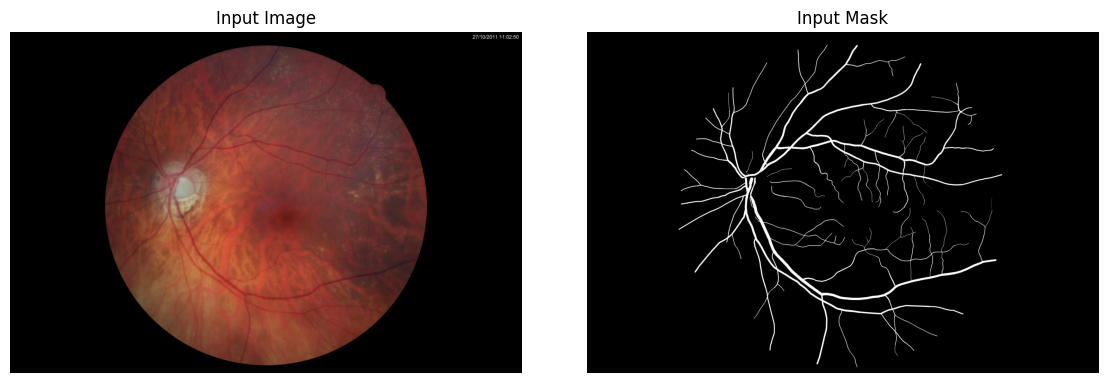

-----------------------------------------------------------------------------*****--------------------------------------------------------------------


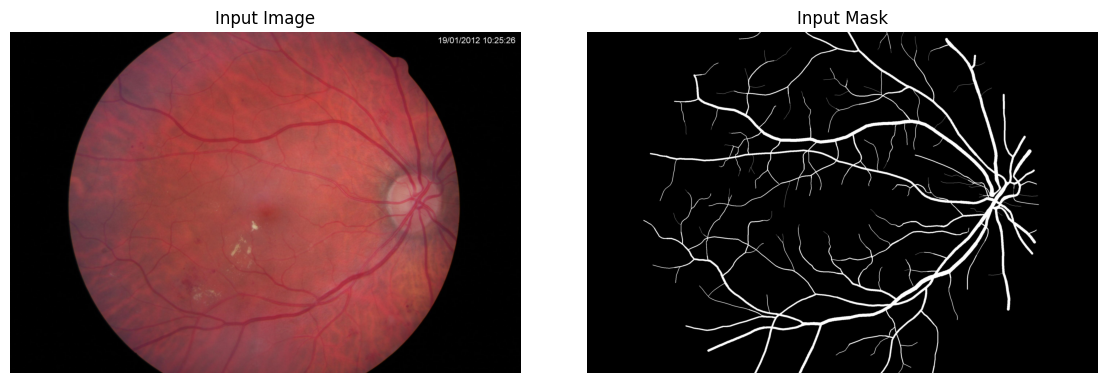

-----------------------------------------------------------------------------*****--------------------------------------------------------------------


In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_images(imgs_lst, masks_lst, loops=2):
    for i in range(loops):
        img_path = os.path.join(train_img_path, imgs_lst[i])
        mask_path = os.path.join(train_mask_path, masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.tight_layout()

        # Plot input image
        ax1.axis('off')
        ax1.set_title('Input Image')
        ax1.imshow(img)

        # Plot input mask
        ax2.axis('off')
        ax2.set_title('Input Mask')
        ax2.imshow(mask, cmap='gray')
        plt.subplots_adjust(wspace=0.05)

        plt.show()
        print("-----------------------------------------------------------------------------*****--------------------------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst)

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset

class DISdataset(Dataset):
    def __init__(self, img_list, mask_list, transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img_path = os.path.join(train_img_path, self.img_list[index])
        mask_path = os.path.join(train_mask_path, self.mask_list[index])
        
        # Load image and mask
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
                        
        return {'img': img, 'mask': mask}

In [10]:
import random
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor

# Set a seed value for reproducibility
random.seed(42)

# Split the data into train, validation, and test sets
train_indices, test_indices = train_test_split(range(len(train_img_lst)), test_size=0.1, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1, random_state=42)

train_transform = Compose([
    Resize((512, 512)),  # Resize the image to 512x512
    ToTensor()
])
val_transform = Compose([
    Resize((512, 512)),  # Resize the image to 512x512
    ToTensor()
])
test_transform = Compose([
    Resize((512, 512)),  # Resize the image to 512x512
    ToTensor()
])

# Create dataset instances for training, validation, and testing
train_dataset = DISdataset([train_img_lst[i] for i in train_indices], [train_mask_lst[i] for i in train_indices], transform=train_transform)
val_dataset = DISdataset([train_img_lst[i] for i in val_indices], [train_mask_lst[i] for i in val_indices], transform=val_transform)
test_dataset = DISdataset([train_img_lst[i] for i in test_indices], [train_mask_lst[i] for i in test_indices], transform=test_transform)

# Define the batch size for training, validation, and testing
batch_size = 1

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

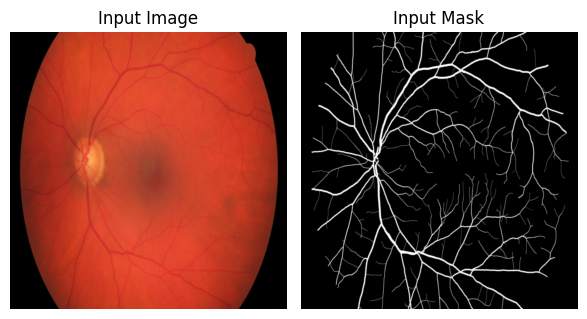

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Assuming you already have loaded your dataset and defined your train_loader

# Get a batch of samples from the train_loader
samples = next(iter(train_loader))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()

# Plot input image
ax1.axis('off')
ax1.set_title('Input Image')
# Convert image tensor to numpy array and transpose the dimensions
img_np = np.transpose(samples['img'][0].numpy(), (1, 2, 0))
ax1.imshow(img_np)

# Plot input mask
ax2.axis('off')
ax2.set_title('Input Mask')
# Convert mask tensor to numpy array and squeeze to remove single-channel dimension
mask_np = samples['mask'][0].numpy().squeeze()
ax2.imshow(mask_np, cmap='gray')
plt.subplots_adjust(wspace=0.05)

plt.show()

# Model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dilation=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, dilation=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class TransUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(TransUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64, dilation=2)  # Set dilation=2 for the first convolutional layer

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)

        logits = self.outc(x9)
        logits = torch.sigmoid(logits)
        return logits

# Metrics

In [20]:
def dice_score(pred: torch.Tensor, mask: torch.Tensor):
    dice = (2 * (pred * mask).sum()) / (pred + mask).sum()
    return (dice.cpu().numpy())

'''def iou_score(pred: torch.Tensor, mask: torch.Tensor):
    intersection = torch.logical_and(pred, mask).sum()
    union = torch.logical_or(pred, mask).sum()
    iou = intersection.float() / union.float()
    return iou'''
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task='binary', num_classes=2).to(device)

from torchmetrics.classification import BinaryAccuracy
train_accuracy = BinaryAccuracy().to(device)
valid_accuracy = BinaryAccuracy().to(device)
test_accuracy = BinaryAccuracy().to(device)
'''def pixel_accuracy(pred: torch.Tensor, mask: torch.Tensor):
    correct = torch.eq(pred, mask).int()
    return float(correct.sum()) / float(correct.numel())'''

from torchmetrics.classification import BinaryRecall
metric = BinaryRecall().to(device)

from torchmetrics.classification import BinaryPrecision
metric1 = BinaryPrecision().to(device)

from torchmetrics.classification import BinarySpecificity
metric2 = BinarySpecificity().to(device)

# Plot

In [21]:
def plot_pred_img(samples, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
    fig.tight_layout()


    ax1.axis('off')
    ax1.set_title('input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                           (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                           (1, 2, 0)), cmap='gray')
    
    ax3.axis('off')
    ax3.set_title('predicted mask')
    ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(),
                           (1, 2, 0)), cmap='gray')

    plt.show()
    
    
def plot_train_progress_A(model):
#     model.eval()

#     with torch.no_grad():
    samples = next(iter(val_loader))
    val_img = samples['img'].to(CFG.device)
    val_mask = samples['mask'].to(CFG.device)

    pred = model(val_img)
    #fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_pred_img(samples, pred.detach())

In [22]:
def plot_train_progress(epoch, model, samples, pred):
    if epoch == 40:
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
        fig.tight_layout()

        ax1.axis('off')
        ax1.set_title('input image')
        ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                                (1, 2, 0)))

        ax2.axis('off')
        ax2.set_title('input mask')
        ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                                (1, 2, 0)), cmap='gray')

        ax3.axis('off')
        ax3.set_title('predicted mask')
        ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(),
                                (1, 2, 0)), cmap='gray')

        plt.show()

In [23]:
class BestMetric:
    def __init__(self):
        self.best_value = float('-inf')
    
    def update(self, value):
        if value > self.best_value:
            self.best_value = value
        return self.best_value
    
    def reset(self):
        self.best_value = float('-inf')
    
    def get_best(self):
        return self.best_value

In [29]:
import warnings
warnings.filterwarnings('ignore')


def train(model, optimizer, criterion, scheduler=None):
    train_losses = []
    val_losses = []
    train_accs = []
    valid_accs = []
    dice_scores = []  # List to store Dice coefficients
    lr_rates = []

    best_metric1 = BestMetric()
    best_metric2 = BestMetric()
    best_metric3 = BestMetric()
    best_metric4 = BestMetric()
    best_metric5 = BestMetric()

    for epoch in range(CFG.epochs):
        model.train()
        train_total_loss = 0
        train_iterations = 0
        train_acc_total = 0

        for idx, data in enumerate(tqdm(train_loader)):
            train_iterations += 1
            train_img = data['img'].to(device)
            train_mask = data['mask'].to(device)
            threshold = 0.5
            train_mask1 = (train_mask >= threshold).float()

            optimizer.zero_grad()
            with torch.autocast(device_type='cuda'):
                train_output_mask = model(train_img)
                train_loss = criterion(train_output_mask, train_mask)
                train_total_loss += train_loss.item()
                train_acc_total += train_accuracy(train_output_mask, train_mask1)

            train_loss.backward()
            optimizer.step()

        train_epoch_loss = train_total_loss / train_iterations
        train_acc = train_acc_total / train_iterations
        train_losses.append(train_epoch_loss)
        train_accs.append(train_acc)

        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_iterations = 0
            total_valid_acc = 0
            scores = 0

            for vidx, val_data in enumerate(tqdm(val_loader)):
                val_iterations += 1
                val_img = val_data['img'].to(device)
                val_mask = val_data['mask'].to(device)
                threshold = 0.5
                val_mask1 = (val_mask >= threshold).float()

                with torch.autocast(device_type='cuda'):
                    pred = model(val_img)
                    val_loss = criterion(pred, val_mask)
                    val_total_loss += val_loss.item()
                    total_valid_acc += valid_accuracy(pred, val_mask1)
                    scores += dice_score(pred, val_mask)
            
            val_epoch_loss = val_total_loss / val_iterations
            val_acc = total_valid_acc / val_iterations
            val_losses.append(val_epoch_loss)
            valid_accs.append(val_acc)
            dice_coef_score = scores / val_iterations
            dice_scores.append(dice_coef_score)  # Store Dice coefficient

            best_metric1.update(dice_coef_score)
            best_metric2.update(jaccard(pred, val_mask1))
            best_metric3.update(metric1(pred, val_mask1))
            best_metric4.update(train_acc)
            best_metric5.update(val_acc)

            if epoch == 5:
                samples = next(iter(val_loader))
                val_img = samples['img'].to(CFG.device)
                val_mask = samples['mask'].to(CFG.device)
                pred = model(val_img)
                plot_train_progress(epoch, model, samples, pred.detach())

            print('epochs - {}/{} [{}/{}], dice score: {}, train loss: {}, val loss: {}, iou score:{}, train_accuracy:{}, valid_accuracy:{}, Recall:{}, Precision:{}, Specificity:{}'.format(
                epoch+1, epochs,
                idx+1, len(train_loader),
                dice_coef_score, train_epoch_loss, val_epoch_loss, jaccard(pred, val_mask1), train_acc, val_acc, metric(pred, val_mask1), metric1(pred, val_mask1), metric2(pred, val_mask1) 
            ))

        lr_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            scheduler.step()

    best_DiceScore = best_metric1.get_best()
    best_IoUscore = best_metric2.get_best()
    best_precision = best_metric3.get_best()
    best_TrainAcc = best_metric4.get_best()
    best_ValidAcc = best_metric5.get_best()
    print('Best Dice Score: {:.4f}'.format(best_DiceScore))
    print('Best IoU Score: {:.4f}'.format(best_IoUscore))
    print('Best Precision: {:.4f}'.format(best_precision))
    print('Best Train Accuracy: {:.4f}'.format(best_TrainAcc))
    print('Best Valid Accuracy: {:.4f}'.format(best_ValidAcc))

    return {
        'lr': lr_rates,
        'train_loss': train_losses,
        'valid_loss': val_losses,
        'train_acc': train_accs,
        'valid_acc': valid_accs,
        'dice_scores': dice_scores  # Include dice scores in the returned dictionary
    }

In [30]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, gamma=0.2, beta=0.8):
        super(DiceBCELoss, self).__init__()
        self.gamma = gamma
        self.beta = beta

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        BCE_with_Logits = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')

        # Apply gamma and beta coefficients
        dice_loss = self.beta * dice_loss
        BCE_with_Logits = self.gamma * BCE_with_Logits

        Dice_BCE = BCE_with_Logits + dice_loss

        return Dice_BCE

In [31]:
model = TransUNet(n_channels=3, n_classes=1)
model = model.to(CFG.device)
#criterion = nn.BCEWithLogitsLoss()
#criterion = smp.losses.DiceLoss(mode='binary')
criterion = DiceBCELoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
#optimizer = AdaBound(model.parameters(), lr=0.001, final_lr=0.1)
#history = train(model, optimizer, criterion)
#early_stopping = EarlyStopping(patience=5, delta=0.001)
#early_stopper = EarlyStop(patience=5, delta=0.001)

In [32]:
import torch

# Get a batch of images from the train_dataset_loader
samples = next(iter(train_loader))

# Extract an image from the batch (assuming batch size is greater than 0)
image = samples['img'][0]  # Assuming 'img' is the key for images in your dataset

# Pass the image through the model for prediction
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    image = image.unsqueeze(0).to(CFG.device)  # Add batch dimension and move to device
    prediction = model(image)

# Assuming prediction contains the predicted output
# You can further process or visualize the prediction as needed

In [33]:
history = train(model, optimizer, criterion)

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 1/50 [117/117], dice score: 0.24343367780630404, train loss: 0.8099488070887378, val loss: 0.7911282044190627, iou score:0.20730768144130707, train_accuracy:0.6979739665985107, valid_accuracy:0.61288982629776, Recall:0.96674644947052, Precision:0.20879657566547394, Specificity:0.6551483869552612


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 2/50 [117/117], dice score: 0.2844651135114523, train loss: 0.7763136716989371, val loss: 0.73999606187527, iou score:0.4295200705528259, train_accuracy:0.8172829747200012, valid_accuracy:0.8417279720306396, Recall:0.820209264755249, Precision:0.47416311502456665, Specificity:0.9143745303153992


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 3/50 [117/117], dice score: 0.30913999447455776, train loss: 0.7538290991742387, val loss: 0.7156514342014606, iou score:0.47775477170944214, train_accuracy:0.8413040041923523, valid_accuracy:0.8620925545692444, Recall:0.7770240306854248, Precision:0.553659975528717, Specificity:0.9410325884819031


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 4/50 [117/117], dice score: 0.3338125886825415, train loss: 0.7319827405815451, val loss: 0.6899595031371484, iou score:0.500135600566864, train_accuracy:0.8671337962150574, valid_accuracy:0.9237333536148071, Recall:0.8175933361053467, Precision:0.5629503130912781, Specificity:0.9402479529380798


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 5/50 [117/117], dice score: 0.33240211124603564, train loss: 0.7097295869109977, val loss: 0.6867359280586243, iou score:0.5407947897911072, train_accuracy:0.8826398849487305, valid_accuracy:0.936426043510437, Recall:0.7494014501571655, Precision:0.660182774066925, Specificity:0.9636879563331604


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 6/50 [117/117], dice score: 0.3807785671490889, train loss: 0.6841243291512514, val loss: 0.6458301498339727, iou score:0.10770490765571594, train_accuracy:0.8986488580703735, valid_accuracy:0.9369483590126038, Recall:0.2215128093957901, Precision:0.1733037382364273, Specificity:0.9005300998687744


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 7/50 [117/117], dice score: 0.3943309405675301, train loss: 0.6574404463808761, val loss: 0.6329993513914255, iou score:0.5578171014785767, train_accuracy:0.9100733995437622, valid_accuracy:0.9398243427276611, Recall:0.7813248038291931, Precision:0.6610150337219238, Specificity:0.9622814059257507


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 8/50 [117/117], dice score: 0.43387771340516895, train loss: 0.6302432573249197, val loss: 0.5983564532720126, iou score:0.5898023843765259, train_accuracy:0.9212045669555664, valid_accuracy:0.9510031938552856, Recall:0.7529041171073914, Precision:0.7313722372055054, Specificity:0.9739680290222168


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 9/50 [117/117], dice score: 0.42235261316482836, train loss: 0.6021288210510188, val loss: 0.6067499747643104, iou score:0.5797872543334961, train_accuracy:0.9315455555915833, valid_accuracy:0.9484699368476868, Recall:0.7249268293380737, Precision:0.7433169484138489, Specificity:0.9764347672462463


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 10/50 [117/117], dice score: 0.48388946858736187, train loss: 0.5721526701226194, val loss: 0.5565329537941859, iou score:0.5988336205482483, train_accuracy:0.9407411813735962, valid_accuracy:0.9500245451927185, Recall:0.778531551361084, Precision:0.721790611743927, Specificity:0.9717517495155334


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 11/50 [117/117], dice score: 0.5179084195540502, train loss: 0.5452829882120475, val loss: 0.5271684871270106, iou score:0.6020488142967224, train_accuracy:0.9481200575828552, valid_accuracy:0.9537626504898071, Recall:0.7478495836257935, Precision:0.7553853988647461, Specificity:0.9772027134895325


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 12/50 [117/117], dice score: 0.4785033166408539, train loss: 0.5210088020206517, val loss: 0.5576696579272931, iou score:0.5127663612365723, train_accuracy:0.9534544944763184, valid_accuracy:0.9544252753257751, Recall:0.5600780248641968, Precision:0.8585604429244995, Specificity:0.9913143515586853


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 13/50 [117/117], dice score: 0.5484439707719363, train loss: 0.5005950380084861, val loss: 0.5010547431615683, iou score:0.5896334052085876, train_accuracy:0.9570837020874023, valid_accuracy:0.9567402005195618, Recall:0.6874611973762512, Precision:0.8055800795555115, Specificity:0.9843816757202148


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 14/50 [117/117], dice score: 0.5864935631935413, train loss: 0.4821646531932374, val loss: 0.4699829679269057, iou score:0.6169765591621399, train_accuracy:0.9598110914230347, valid_accuracy:0.95737224817276, Recall:0.7547663450241089, Precision:0.7716681957244873, Specificity:0.9789766073226929


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 15/50 [117/117], dice score: 0.5779021244782668, train loss: 0.46388349854029143, val loss: 0.47644180288681615, iou score:0.599560558795929, train_accuracy:0.9618861079216003, valid_accuracy:0.9591736793518066, Recall:0.677529513835907, Precision:0.8389700055122375, Specificity:0.9877582788467407


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 16/50 [117/117], dice score: 0.6024714089356936, train loss: 0.44818951991888195, val loss: 0.4558177384046408, iou score:0.6075540781021118, train_accuracy:0.9639243483543396, valid_accuracy:0.9593972563743591, Recall:0.6925157308578491, Precision:0.8319927453994751, Specificity:0.9868358373641968


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 17/50 [117/117], dice score: 0.5963202164723322, train loss: 0.4360992528943934, val loss: 0.46042866890247053, iou score:0.5830087065696716, train_accuracy:0.9655358791351318, valid_accuracy:0.9577484726905823, Recall:0.6569123268127441, Precision:0.8382461071014404, Specificity:0.988067090511322


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 18/50 [117/117], dice score: 0.5908105373382568, train loss: 0.42624496267392087, val loss: 0.46514829763999355, iou score:0.5698785185813904, train_accuracy:0.9662764072418213, valid_accuracy:0.9567824602127075, Recall:0.6427241563796997, Precision:0.8341101408004761, Specificity:0.9879669547080994


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 19/50 [117/117], dice score: 0.6199030715685624, train loss: 0.4167434705628289, val loss: 0.44143540354875416, iou score:0.595111072063446, train_accuracy:0.967637300491333, valid_accuracy:0.9589688777923584, Recall:0.6627649068832397, Precision:0.8535861372947693, Specificity:0.989298403263092


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 20/50 [117/117], dice score: 0.5942008701654581, train loss: 0.4072479256707379, val loss: 0.46192044707444996, iou score:0.5601110458374023, train_accuracy:0.9689574241638184, valid_accuracy:0.9576627612113953, Recall:0.6172297596931458, Precision:0.8582084774971008, Specificity:0.9904002547264099


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 21/50 [117/117], dice score: 0.5973824537717379, train loss: 0.4010733225916186, val loss: 0.4591880005139571, iou score:0.5615062713623047, train_accuracy:0.9696462154388428, valid_accuracy:0.9569942951202393, Recall:0.6122195720672607, Precision:0.8714420795440674, Specificity:0.9914979934692383


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 22/50 [117/117], dice score: 0.6314146266533778, train loss: 0.3955023416087159, val loss: 0.43208027344483596, iou score:0.5792295932769775, train_accuracy:0.9698537588119507, valid_accuracy:0.9571436643600464, Recall:0.675356924533844, Precision:0.8027404546737671, Specificity:0.9843775033950806


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 23/50 [117/117], dice score: 0.6356576520663041, train loss: 0.3898347557609917, val loss: 0.42852237132879406, iou score:0.6062690615653992, train_accuracy:0.9710239768028259, valid_accuracy:0.9584060311317444, Recall:0.6954863667488098, Precision:0.8253617286682129, Specificity:0.9861471652984619


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 24/50 [117/117], dice score: 0.6152021678594443, train loss: 0.3844614624977112, val loss: 0.4449341342999385, iou score:0.572068452835083, train_accuracy:0.971820592880249, valid_accuracy:0.957272469997406, Recall:0.6285802721977234, Precision:0.8641877770423889, Specificity:0.9907007813453674


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 25/50 [117/117], dice score: 0.6407908086593335, train loss: 0.38260544365287846, val loss: 0.42431329305355364, iou score:0.6077979803085327, train_accuracy:0.9717601537704468, valid_accuracy:0.9590299129486084, Recall:0.6904761791229248, Precision:0.8354165554046631, Specificity:0.9871947765350342


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 26/50 [117/117], dice score: 0.625450984789775, train loss: 0.37754582721962887, val loss: 0.43648239511709946, iou score:0.57511967420578, train_accuracy:0.9726409316062927, valid_accuracy:0.9578021764755249, Recall:0.6286689639091492, Precision:0.8709994554519653, Specificity:0.9912350177764893


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 27/50 [117/117], dice score: 0.6152293888422159, train loss: 0.3733719707044781, val loss: 0.44461456399697524, iou score:0.5453613996505737, train_accuracy:0.9733705520629883, valid_accuracy:0.957172155380249, Recall:0.5898288488388062, Precision:0.8785497546195984, Specificity:0.9923244118690491


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 28/50 [117/117], dice score: 0.6495316464167374, train loss: 0.3701501585479475, val loss: 0.4171226781148177, iou score:0.6039760708808899, train_accuracy:0.9737573862075806, valid_accuracy:0.9597702622413635, Recall:0.6761993169784546, Precision:0.8497325778007507, Specificity:0.988743245601654


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 29/50 [117/117], dice score: 0.6606739186323606, train loss: 0.36654832551621985, val loss: 0.4083472811258756, iou score:0.6127262115478516, train_accuracy:0.9744971394538879, valid_accuracy:0.9598392248153687, Recall:0.698058009147644, Precision:0.8336775302886963, Specificity:0.9868900775909424


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 30/50 [117/117], dice score: 0.5772657761206994, train loss: 0.36421346282347655, val loss: 0.4750044781428117, iou score:0.4985162019729614, train_accuracy:0.9745458960533142, valid_accuracy:0.9534522294998169, Recall:0.528819739818573, Precision:0.8969017863273621, Specificity:0.9942777156829834


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 31/50 [117/117], dice score: 0.5745969987832583, train loss: 0.3609461781815586, val loss: 0.47710997553972095, iou score:0.48537155985832214, train_accuracy:0.9749794602394104, valid_accuracy:0.9532755613327026, Recall:0.5148975849151611, Precision:0.8943396210670471, Specificity:0.9942735433578491


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 32/50 [117/117], dice score: 0.6081075805884141, train loss: 0.35710659393897426, val loss: 0.45017600518006545, iou score:0.5210764408111572, train_accuracy:0.9755758047103882, valid_accuracy:0.9559831023216248, Recall:0.5563092827796936, Precision:0.8916287422180176, Specificity:0.9936349391937256


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 33/50 [117/117], dice score: 0.6235033915593073, train loss: 0.3547949426703983, val loss: 0.4379856311357938, iou score:0.5694864988327026, train_accuracy:0.9759530425071716, valid_accuracy:0.956476092338562, Recall:0.6333687901496887, Precision:0.8495391011238098, Specificity:0.9894403219223022


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 34/50 [117/117], dice score: 0.6056612294453841, train loss: 0.3528826109364501, val loss: 0.45212732828580415, iou score:0.5274181365966797, train_accuracy:0.9761627912521362, valid_accuracy:0.955230176448822, Recall:0.567172110080719, Precision:0.882693886756897, Specificity:0.992904543876648


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 35/50 [117/117], dice score: 0.6003137207948245, train loss: 0.35114656656216353, val loss: 0.45646384129157436, iou score:0.5324482917785645, train_accuracy:0.9764355421066284, valid_accuracy:0.9548724889755249, Recall:0.5743992328643799, Precision:0.8793781995773315, Specificity:0.992583155632019


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 36/50 [117/117], dice score: 0.6267569042169131, train loss: 0.349645921562472, val loss: 0.43523759796069217, iou score:0.5723817944526672, train_accuracy:0.976664125919342, valid_accuracy:0.9567422270774841, Recall:0.6237474679946899, Precision:0.8742232322692871, Specificity:0.9915522336959839


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 37/50 [117/117], dice score: 0.6473915897882901, train loss: 0.34894743841937464, val loss: 0.4186504758321322, iou score:0.5931220650672913, train_accuracy:0.9765793085098267, valid_accuracy:0.9588608741760254, Recall:0.6530548930168152, Precision:0.866004228591919, Specificity:0.9904879331588745


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 38/50 [117/117], dice score: 0.6365360182065231, train loss: 0.34617390846594787, val loss: 0.42744452678240263, iou score:0.5642563700675964, train_accuracy:0.9772596955299377, valid_accuracy:0.956958532333374, Recall:0.6213975548744202, Precision:0.8598687052726746, Specificity:0.9904670715332031


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 39/50 [117/117], dice score: 0.6448631103222187, train loss: 0.3442081923668201, val loss: 0.4206865888375502, iou score:0.5855265855789185, train_accuracy:0.9777204990386963, valid_accuracy:0.9585005044937134, Recall:0.6421477198600769, Precision:0.8691190481185913, Specificity:0.9908969402313232


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 40/50 [117/117], dice score: 0.6328554061742929, train loss: 0.3425289858610202, val loss: 0.43023441617305463, iou score:0.5601012706756592, train_accuracy:0.9778928756713867, valid_accuracy:0.9573479294776917, Recall:0.6082291603088379, Precision:0.8762136101722717, Specificity:0.9919111728668213


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 41/50 [117/117], dice score: 0.6262897344735953, train loss: 0.34101532463334566, val loss: 0.435590365758309, iou score:0.5584622025489807, train_accuracy:0.978336751461029, valid_accuracy:0.9567765593528748, Recall:0.6067216396331787, Precision:0.8753278255462646, Specificity:0.9918652772903442


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 42/50 [117/117], dice score: 0.5943403289868281, train loss: 0.3407457488724309, val loss: 0.46115156549673814, iou score:0.5015339255332947, train_accuracy:0.9781759977340698, valid_accuracy:0.9546236395835876, Recall:0.5291301012039185, Precision:0.9058064222335815, Specificity:0.9948202967643738


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 43/50 [117/117], dice score: 0.5647967687019935, train loss: 0.33924384962799203, val loss: 0.4849044909844032, iou score:0.45225051045417786, train_accuracy:0.9785110950469971, valid_accuracy:0.951509952545166, Recall:0.47579142451286316, Precision:0.9013859629631042, Specificity:0.9950999617576599


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 44/50 [117/117], dice score: 0.6149542973591731, train loss: 0.3386495194883428, val loss: 0.4445775013703566, iou score:0.5319201946258545, train_accuracy:0.9784632921218872, valid_accuracy:0.9556568264961243, Recall:0.5685465931892395, Precision:0.8919727206230164, Specificity:0.9935181140899658


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 45/50 [117/117], dice score: 0.6142748250411108, train loss: 0.3354162456642868, val loss: 0.44507824228360104, iou score:0.5406364798545837, train_accuracy:0.9792993664741516, valid_accuracy:0.956245481967926, Recall:0.5807395577430725, Precision:0.8867375254631042, Specificity:0.9930172562599182


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 46/50 [117/117], dice score: 0.6415189183675326, train loss: 0.33321466991025156, val loss: 0.4234621547735654, iou score:0.6007159948348999, train_accuracy:0.9799472689628601, valid_accuracy:0.9576569199562073, Recall:0.6695929765701294, Precision:0.8537991642951965, Specificity:0.9892065525054932


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 47/50 [117/117], dice score: 0.6361055672168732, train loss: 0.33262822337639636, val loss: 0.42751552966924816, iou score:0.5453869700431824, train_accuracy:0.98014897108078, valid_accuracy:0.957990825176239, Recall:0.5855280756950378, Precision:0.8883358240127563, Specificity:0.9930714964866638


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 48/50 [117/117], dice score: 0.5871362961255587, train loss: 0.33218645107032907, val loss: 0.4669145666635953, iou score:0.4863503873348236, train_accuracy:0.980089008808136, valid_accuracy:0.9532787799835205, Recall:0.5181785821914673, Precision:0.8878675103187561, Specificity:0.9938395023345947


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 49/50 [117/117], dice score: 0.5914988747009864, train loss: 0.332694825453636, val loss: 0.4634228738454672, iou score:0.498127818107605, train_accuracy:0.9799116849899292, valid_accuracy:0.9531951546669006, Recall:0.5308592915534973, Precision:0.8898550868034363, Specificity:0.9938144087791443


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epochs - 50/50 [117/117], dice score: 0.6418331838571109, train loss: 0.331613832559341, val loss: 0.42298490038284886, iou score:0.5563850998878479, train_accuracy:0.9799909591674805, valid_accuracy:0.9581357836723328, Recall:0.5980757474899292, Precision:0.8886619806289673, Specificity:0.9929462671279907
Best Dice Score: 0.6607
Best IoU Score: 0.6170
Best Precision: 0.9058
Best Train Accuracy: 0.9801
Best Valid Accuracy: 0.9598


# Test

In [34]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [35]:
create_dir("new_data/image_150_D1/")

In [38]:
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont

In [39]:
font_size = 22
font_path = "/kaggle/input/fontss/Agdasima-Bold.ttf"  # Update the path based on your font file location
font = ImageFont.truetype(font_path, size=font_size)

In [44]:
def test(model, test_dataset, criterion, save_dir):
    model.eval()
    test_loss = 0
    test_iterations = 0 
    dice_score_total = 0
    iou_score_total = 0
    
    transform = transforms.ToPILImage() 
    gap_size = 20  # Adjust the gap size between the images

    with torch.no_grad():
        for idx, data in enumerate(tqdm(test_loader)):
            test_iterations += 1
            test_img = data['img'].to(device)
            test_mask = data['mask'].to(device)
            threshold = 0.5  # You can adjust this threshold based on your needs
            test_mask1 = (test_mask >= threshold).float()

            with torch.autocast(device_type='cuda'):
                test_output_mask = model(test_img)
                test_loss = criterion(test_output_mask, test_mask)
                test_accuracy.update(test_output_mask, test_mask1)
                dice_score_batch = dice_score(test_output_mask, test_mask) 
                dice_score_total += dice_score_batch
                
                for i in range(test_img.size(0)):
                    img = transform(test_img[i].cpu())
                    mask = transform(test_mask[i].cpu())
                    predicted_mask = transform(test_output_mask[i].cpu())
                    img_width, img_height = img.size
                    combined_img_width = img_width * 3 + gap_size * 2
                    combined_img_height = img_height + gap_size * 2
                    combined_img = Image.new('RGB', (combined_img_width, combined_img_height), color='white')
                    combined_img.paste(img, (gap_size, gap_size))
                    combined_img.paste(mask, (img_width + gap_size * 2, gap_size))
                    combined_img.paste(predicted_mask, (img_width * 2 + gap_size * 3, gap_size))

                    draw = ImageDraw.Draw(combined_img)
                   # font_size = 20  # Adjust the font size here
             #       font = ImageFont.truetype("Agdasima-Bold.ttf", size=font_size)
                    draw.text((gap_size, 0), "Original Image", fill="black", font=font)
                    draw.text((img_width + gap_size * 2, 0), "Ground Truth Mask", fill="black", font=font)
                    draw.text((img_width * 2 + gap_size * 3, 0), "Predicted Mask", fill="black", font=font)

                    combined_img.save(os.path.join(save_dir, f'frame_{idx * test_loader.batch_size + i}.png'))

    test_epoch_loss = test_loss / test_iterations
    total_test_accuracy = test_accuracy.compute()
    average_dice_score = dice_score_total / test_iterations
    
    plot_train_progress_A(model)
    print('Test loss: {}, Test accuracy: {}, Dice score: {}, IoU score: {}, Recall:{}, Precision:{}, Specificity:{}'.format(test_epoch_loss, total_test_accuracy, average_dice_score, jaccard(test_output_mask, test_mask1),metric(test_output_mask, test_mask1), metric1(test_output_mask, test_mask1), metric2(test_output_mask, test_mask1) ))

    return test_epoch_loss, total_test_accuracy, average_dice_score

  0%|          | 0/15 [00:00<?, ?it/s]

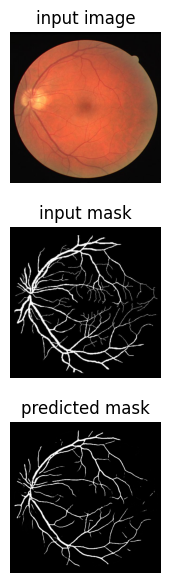

Test loss: 0.0338081531226635, Test accuracy: 0.9610238075256348, Dice score: 0.6279043277104696, IoU score: 0.4409044086933136, Recall:0.606789231300354, Precision:0.6172661781311035, Specificity:0.9917033314704895


ValueError: too many values to unpack (expected 2)

In [45]:
save_dir = '/kaggle/working/new_data/image_150_D1'
test_loss, test_accuracy = test(model, test_dataset, criterion, save_dir)

# Graphs

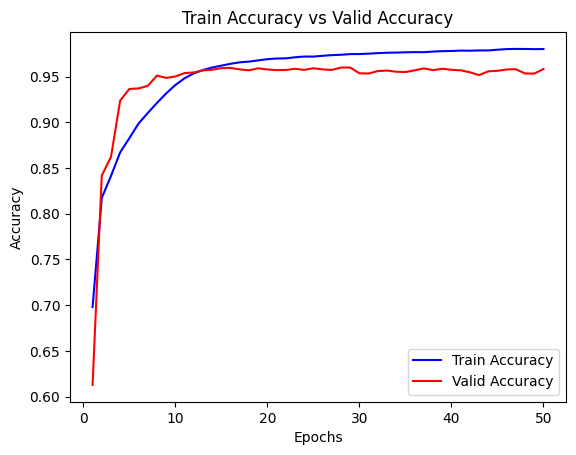

In [46]:
# Accuracy graph
def plot_accuracy(train_acc, valid_acc):
    epochs = range(1, len(train_acc) + 1)
    train_acc_cpu = [acc.cpu().numpy() for acc in train_acc]  # Convert train_acc to CPU
    valid_acc_cpu = [acc.cpu().numpy() for acc in valid_acc]  # Convert valid_acc to CPU
    plt.plot(epochs, train_acc_cpu, 'b', label='Train Accuracy')
    plt.plot(epochs, valid_acc_cpu, 'r', label='Valid Accuracy')
    plt.title('Train Accuracy vs Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
train_acc = history['train_acc']
valid_acc = history['valid_acc']
plot_accuracy(train_acc, valid_acc)

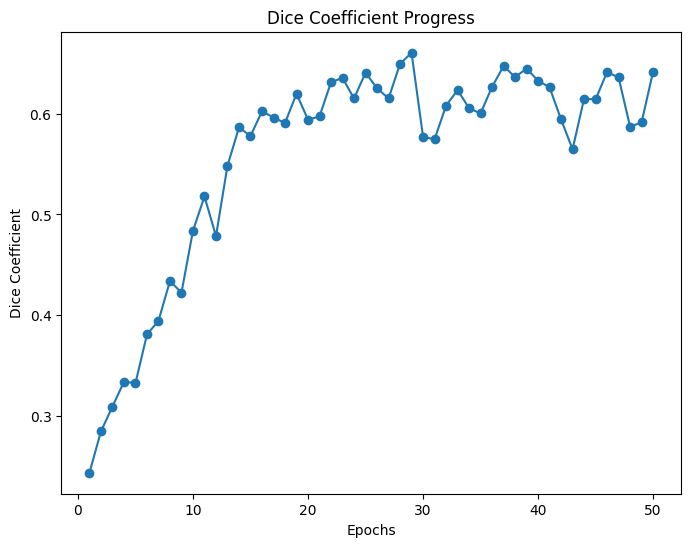

In [47]:
# Plotting the Dice coefficients
epochs = range(1, len(history['dice_scores']) + 1)
dice_scores = history['dice_scores']

plt.figure(figsize=(8, 6))
plt.plot(epochs, dice_scores, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Progress')
plt.show()

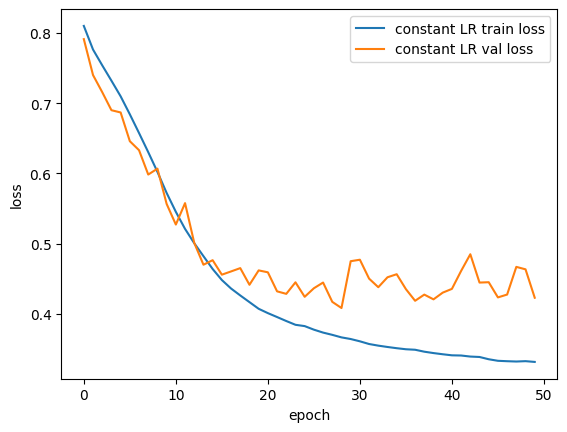

In [48]:
# Loss Graph
plt.plot(history['train_loss'], label='constant LR train loss')
plt.plot(history['valid_loss'], label='constant LR val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Saving Model

In [49]:
import shutil

# Create a zip file
shutil.make_archive('/kaggle/working/new_data/image_150_D1', 'zip', save_dir)

'/kaggle/working/new_data/image_150_D1.zip'

In [50]:
import torch

# Save the entire model
torch.save(model, 'model_150_D1.pth')

# Save only the model state dictionary
torch.save(model.state_dict(), 'model_state_150_D1.pth')